In [1]:
import sys
sys.path.append("../")
import torch
from main import *
import numpy as np
import pickle

Using device: cpu
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/Users/sophia/opt/anaconda3/envs/py31/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sophia/opt/anaconda3/envs/py31/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /Users/sophia/projects/PerceptualSimilarity/lpips/weights/v0.1/alex.pth


In [2]:
file = open("../logs/results.pkl",'rb')
results = pickle.load(file)

In [5]:
model = get_model()
trainloader, testloader = get_data()

Loading pretrained model
Getting data
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def get_block_weights(block, layer_idx, block_idx, weight_dict={}):
    weight_dict['layer{}_block{}_conv1'.format(layer_idx, block_idx)] = block.conv1._parameters['weight'].detach()
    weight_dict['layer{}_block{}_conv2'.format(layer_idx, block_idx)] = block.conv2._parameters['weight'].detach()
    weight_dict['layer{}_block{}_conv3'.format(layer_idx, block_idx)] = block.conv3._parameters['weight'].detach()
    return weight_dict

def get_layer_weights(layer, layer_idx, n_blocks, weight_dict={}):
    for b in range(n_blocks):
        block_weights = get_block_weights(layer[b], layer_idx, b, weight_dict)
    return weight_dict

def get_weights(model):
    weight_dict = {}
    weight_dict = get_layer_weights(model.layer1, layer_idx=1, n_blocks=3, weight_dict=weight_dict)
    weight_dict = get_layer_weights(model.layer2, layer_idx=2, n_blocks=4, weight_dict=weight_dict)
    weight_dict = get_layer_weights(model.layer3, layer_idx=3, n_blocks=6, weight_dict=weight_dict)
    weight_dict = get_layer_weights(model.layer4, layer_idx=4, n_blocks=3, weight_dict=weight_dict)
    return weight_dict

In [ ]:
def get_interferences(weight_dict):
    interferences = {}
    polysemanticity = {}
    for name, W in weight_dict.items():
        W = W.reshape(W.shape[0], W.shape[1] * W.shape[2] * W.shape[3])
        W_norm = W / (1e-5 + torch.linalg.norm(W, 2, dim=-1, keepdim=True))
        interference = W_norm.T @ W
        n_features = int(interference.shape[0])
        interference[torch.arange(n_features), torch.arange(n_features)] = 0
        interferences[name] = interference
        polysemanticity[name] = torch.linalg.norm(interference, dim=-1)
    return interferences, polysemanticity

In [97]:
weight_dict = get_weights(model)

In [88]:
len(weight_dict.keys())

48

In [50]:
covs = {}
for k, v in weight_dict.items():
    covs[k] = np.corrcoef(v.reshape(v.shape[0], v.shape[1] * v.shape[2] * v.shape[3]))

In [68]:
WTW = {}
for k, v in weight_dict.items():
    v = v.reshape(v.shape[0], v.shape[1] * v.shape[2] * v.shape[3])
    WTW[k] = v @ v.T

In [119]:
interferences, polysemanticity = get_interferences(weight_dict)
average_polysemanticity = {k: v.mean().numpy() for k,v in polysemanticity.items()}
layer_polysemanticity = np.array(list(average_polysemanticity.values()))

<BarContainer object of 48 artists>

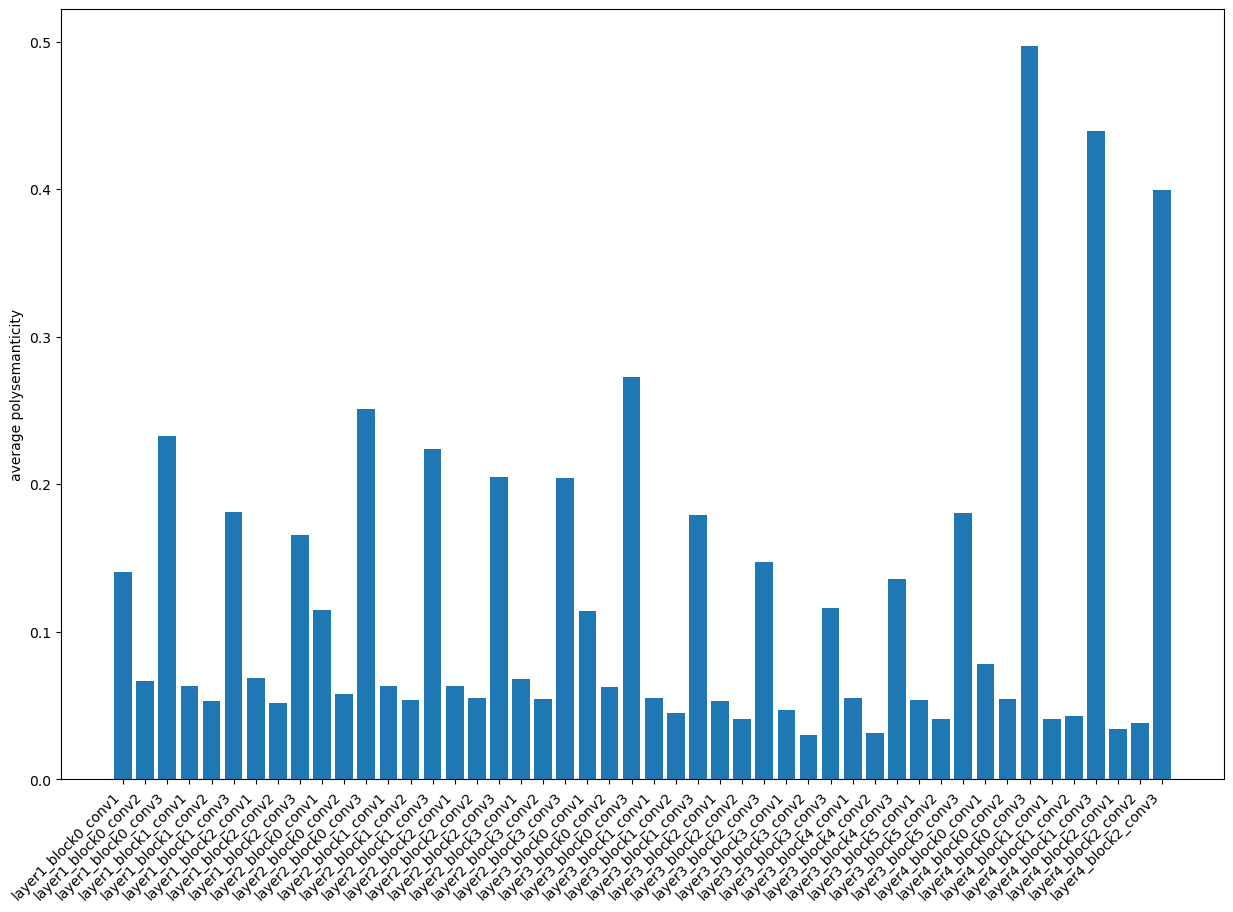

In [149]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.xticks(rotation=45, ha='right')
ax.set_ylabel("average polysemanticity")
# ax.set_xticklabels(ax.get_xlabels(), rotation=45)
plt.bar(average_polysemanticity.keys(), layer_polysemanticity)